### Gesture Based UI Development - Project 1 <br> Ronan Waldron <br> G00384180

---

Data Consistency Analysis Across Vehicles and Runs:
                                                      mean       std
Unnamed: 0 (Opel Corsa Run 1)                 1.292263e-16  1.000071
AltitudeVariation (Opel Corsa Run 1)         -8.076644e-18  1.000071
VehicleSpeedInstantaneous (Opel Corsa Run 1)  7.672812e-17  1.000071
VehicleSpeedAverage (Opel Corsa Run 1)        6.461315e-17  1.000071
VehicleSpeedVariance (Opel Corsa Run 1)       4.038322e-18  1.000071
...                                                    ...       ...
VerticalAcceleration (Peugeot 207 Run 2)      1.917794e-17  1.000112
FuelConsumptionAverage (Peugeot 207 Run 2)    3.068471e-16  1.000112
roadSurface (Peugeot 207 Run 2)              -1.278529e-17  1.000112
traffic (Peugeot 207 Run 2)                  -7.671177e-17  1.000112
drivingStyle (Peugeot 207 Run 2)              3.835588e-17  1.000112

[72 rows x 2 columns]

Feature Selection with RFE - Ranking of Features:
                      Feature  Rank
1   Vehicl

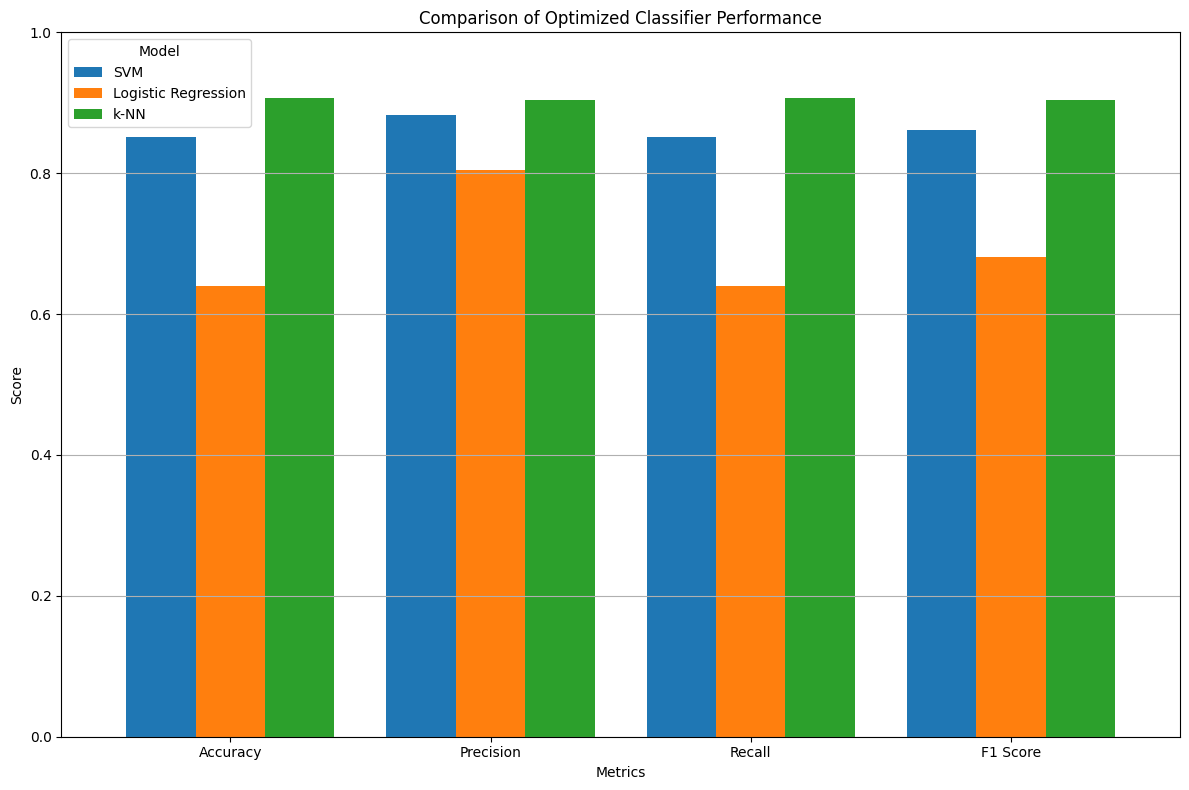

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the datasets
opel_corsa_01 = pd.read_csv('./spreadsheets/opel_corsa_01.csv', delimiter=';')
opel_corsa_02 = pd.read_csv('./spreadsheets/opel_corsa_02.csv', delimiter=';')
peugeot_207_01 = pd.read_csv('./spreadsheets/peugeot_207_01.csv', delimiter=';')
peugeot_207_02 = pd.read_csv('./spreadsheets/peugeot_207_02.csv', delimiter=';')

# Convert categorical target variables to numeric
mapping_roadSurface = {'SmoothCondition': 0, 'UnevenCondition': 1}
mapping_traffic = {'LowCongestionCondition': 0, 'NormalCongestionCondition': 1, 'HighCongestionCondition': 2}
mapping_drivingStyle = {'EvenPaceStyle': 0, 'AggressiveStyle': 1}

for df in [opel_corsa_01, opel_corsa_02, peugeot_207_01, peugeot_207_02]:
    df['roadSurface'] = df['roadSurface'].map(mapping_roadSurface)
    df['traffic'] = df['traffic'].map(mapping_traffic)
    df['drivingStyle'] = df['drivingStyle'].map(mapping_drivingStyle)

# Impute missing values (only on numeric columns)
numeric_columns = opel_corsa_01.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')

for df in [opel_corsa_01, opel_corsa_02, peugeot_207_01, peugeot_207_02]:
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Standardize the features
scaler = StandardScaler()

for df in [opel_corsa_01, opel_corsa_02, peugeot_207_01, peugeot_207_02]:
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Define the target and features (using 'drivingStyle' as the classification target for this example)
target_column = 'drivingStyle'
X_opel = opel_corsa_01.drop(columns=[target_column, 'roadSurface', 'traffic', 'Unnamed: 0'])
y_opel = opel_corsa_01[target_column]

# Ensure the target variable is of integer type
y_opel = y_opel.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_opel, y_opel, test_size=0.3, random_state=42, stratify=y_opel)

# Step 1: Analyze Data Consistency Across Vehicles and Runs
comparison_stats = pd.DataFrame()

for df, label in zip([opel_corsa_01, opel_corsa_02, peugeot_207_01, peugeot_207_02], 
                     ['Opel Corsa Run 1', 'Opel Corsa Run 2', 'Peugeot 207 Run 1', 'Peugeot 207 Run 2']):
    stats = df[numeric_columns].describe().loc[['mean', 'std']]
    stats.columns = [f'{col} ({label})' for col in stats.columns]
    comparison_stats = pd.concat([comparison_stats, stats], axis=1)

# Display the comparison statistics
print("Data Consistency Analysis Across Vehicles and Runs:")
print(comparison_stats.T)

# Step 2: Perform Feature Selection Using RFE
logreg = LogisticRegression(class_weight='balanced', random_state=42)
rfe = RFE(logreg, n_features_to_select=5)  # Selecting the top 5 features
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = pd.DataFrame({'Feature': X_train.columns, 'Rank': rfe.ranking_}).sort_values(by='Rank')
print("\nFeature Selection with RFE - Ranking of Features:")
print(ranking)

# Step 3: Hyperparameter Tuning for All Models
# Define hyperparameter grids
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10]
}
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9]
}

# Initialize models with class weighting where applicable
svm_classifier = SVC(class_weight='balanced', random_state=42)
logreg_classifier = LogisticRegression(class_weight='balanced', random_state=42)
knn_classifier = KNeighborsClassifier()

# Grid search with cross-validation
svm_grid = GridSearchCV(svm_classifier, svm_param_grid, cv=5, scoring='f1_weighted')
logreg_grid = GridSearchCV(logreg_classifier, logreg_param_grid, cv=5, scoring='f1_weighted')
knn_grid = GridSearchCV(knn_classifier, knn_param_grid, cv=5, scoring='f1_weighted')

# Fit grid search
svm_grid.fit(X_train, y_train)
logreg_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)

# Display the best hyperparameters for each model
print("\nBest Hyperparameters:")
print("SVM:", svm_grid.best_params_)
print("Logistic Regression:", logreg_grid.best_params_)
print("k-NN:", knn_grid.best_params_)

# Step 4: Evaluate the Best Models on the Test Set
best_svm = svm_grid.best_estimator_
best_logreg = logreg_grid.best_estimator_
best_knn = knn_grid.best_estimator_

best_svm_pred = best_svm.predict(X_test)
best_logreg_pred = best_logreg.predict(X_test)
best_knn_pred = best_knn.predict(X_test)

# Calculate metrics for the best models
best_svm_scores = {
    'Accuracy': accuracy_score(y_test, best_svm_pred),
    'Precision': precision_score(y_test, best_svm_pred, average='weighted', zero_division=1),
    'Recall': recall_score(y_test, best_svm_pred, average='weighted', zero_division=1),
    'F1 Score': f1_score(y_test, best_svm_pred, average='weighted', zero_division=1)
}

best_logreg_scores = {
    'Accuracy': accuracy_score(y_test, best_logreg_pred),
    'Precision': precision_score(y_test, best_logreg_pred, average='weighted', zero_division=1),
    'Recall': recall_score(y_test, best_logreg_pred, average='weighted', zero_division=1),
    'F1 Score': f1_score(y_test, best_logreg_pred, average='weighted', zero_division=1)
}

best_knn_scores = {
    'Accuracy': accuracy_score(y_test, best_knn_pred),
    'Precision': precision_score(y_test, best_knn_pred, average='weighted', zero_division=1),
    'Recall': recall_score(y_test, best_knn_pred, average='weighted', zero_division=1),
    'F1 Score': f1_score(y_test, best_knn_pred, average='weighted', zero_division=1)
}

# Combine the scores into a DataFrame for comparison
optimized_results_df = pd.DataFrame([best_svm_scores, best_logreg_scores, best_knn_scores], index=['Optimized SVM', 'Optimized Logistic Regression', 'Optimized k-NN'])

# Display the final comparison of models
print("\nOptimized Classifier Performance Comparison:")
print(optimized_results_df)

# Generate visualisations

# Prepare data for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['Optimized SVM', 'Optimized Logistic Regression', 'Optimized k-NN']

# Extract scores for each model
svm_scores = [best_svm_scores[metric] for metric in metrics]
logreg_scores = [best_logreg_scores[metric] for metric in metrics]
knn_scores = [best_knn_scores[metric] for metric in metrics]

# Create a DataFrame for easier plotting
scores_df = pd.DataFrame({
    'Metrics': metrics,
    'SVM': svm_scores,
    'Logistic Regression': logreg_scores,
    'k-NN': knn_scores
})

# Plot bar charts for each metric
scores_df.set_index('Metrics').plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Comparison of Optimized Classifier Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()
